### Tutorial 4 - Sentiment & Frequency of Topics over Time

In the previous tutorials, we explored **what topics are discussed in different parliaments** and **how positively or negatively they are discussed**. We also learned how to compare countries using cosine distances to see which parliaments are most similar in sentiment or topic focus.

In this tutorial, we take a closer look at **how these patterns change over time**. Specifically, we will:
- **Load and read the datasets**
- **Select a timeframe**
- **Calculate and visualize sentiment over time for one selected country (e.g. RS)**
    1) across **all topics**
    2) for **one specific topic** (e.g. 'Health')
- **Analyze average sentiment scores by country and CAP category** using heatmaps
- **Avg. weekly word count**, which reflect parliamentary attention
    - across selected countries (e.g. RS, HU, HR) for one chosen topic (e.g. 'Health')

This approach allows us to answer questions such as:
- *Which CAP topics in Serbia show the most pos. or neg. sentiment over time?*
- *Did sentiment change noticeably during known impactful events, like COVID outbreak, in Serbia?*
- *How does the sentiment change towards 'Health' differ in parliamentary debates in Serbia (RS), Croatia (HR) and Hungary (HU)?* 
- *How did attention to 'Health' evolve in Serbia, Hungary and Croatia? Are there noticeable patterns in weekly word count that suggest changes in parliamentary activity?*

We will approach these questions using **time series analysis**, a method that lets us track trends over regular intervals (e.g. weekly). For example, we can calculate the **average sentiment per week** for each country or for a specific topic. This allows us to see not just the overall sentiment, but also **when peaks or dips occur*, which may correspond to political events, crises or debates. 

In a similar way, we will compute **weekly word counts** by CAP category, which helps us understand **how much attention parliaments devote to each topic over time**. By plotting these trends as heatmaps, we can quickly identify **patterns or shifts in focus** both for individual countries and across all countries. 


**1. Setup & Data Loading**

This setup (installing/importing) libraries and data loading & filtering steps are the **same as in Tutorial 1**. For detailed explanations, see **Tutorial 1, Sections 1-2**.

In [1]:
# Uncomment and run the following line if you haven't installed pandas yet
# !pip install ipywidgets

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
import csv
from pathlib import Path

In [3]:
# Set consistent style
sns.set_theme(style="whitegrid", font_scale=1.2)

In [4]:
# ---- 1. First, we have to increase the CSV field size limit ----
max_int = 2**31 - 1
while True:
    try:
        csv.field_size_limit(max_int)
        break
    except OverflowError:
        max_int = max_int // 10

countries = ["AT", "BA", "BE", "BG", "CZ", "DK", "EE", "ES", "ES-CT", "ES-GA", "ES-PV", 
             "FR", "GB", "GR", "HR", "HU", "IS", "IT", "LV", 
             "NL", "NO", "PL", "PT", "RS", "SE", "SI", "TR", "UA"] #change country codes according to your available datasets

base_dir = Path().resolve()

# ---- 2. Choose what columns to read (including CAP and sentiment columns) ----
cols_to_keep = [
    "id", "date", "lang_code", "lang", "speaker_role", "speaker_MP",
    "speaker_minister", "speaker_party", "speaker_party_name", "party_status",
    "party_orientation", "speaker_id", "speaker_name", "speaker_gender",
    "speaker_birth", "word_count", "CAP_category", "sent3_category", "sent6_category", "sent_logit"
]

# ---- 3. Define dtypes to reduce memory ----
dtypes = {
    "id": str,
    "date": str,
    "lang_code": "category",
    "lang": "category",
    "speaker_role": "category",
    "speaker_MP": "category",
    "speaker_minister": "category",
    "speaker_party": "category",
    "speaker_party_name": "category",
    "party_status": "category",
    "party_orientation": "category",
    "speaker_id": "category",
    "speaker_name": "category",
    "speaker_gender": "category",
    "speaker_birth": "Int32",
    "word_count": "Int32",
    "CAP_category": "category",
    "sent3_category": "category",
    "sent6_category": "category",
    "sent_logit": "float32"
}

# ---- 4. Create lists to accumulate filtered chunks ----
all_chunks = []

for country in countries:
    file_path = base_dir / f"ParlaMint-{country}_processed_no_text.tsv"

    # --- 4.1. Read in chunks using pandas.read_csv ----
    for chunk in pd.read_csv(file_path, sep="\t", usecols=cols_to_keep,
                             dtype=dtypes, chunksize=50_000, engine="python"):
        chunk["country"] = country
        chunk["country"] = chunk["country"].astype("category")

        # ---- 4.2. Filter MPs with regular role ----
        filtered_chunk = chunk.query("speaker_MP == 'MP' and speaker_role == 'Regular'")

        # ---- 4.3. Drop rows where CAP_category or sentiment is empty ----
        filtered_chunk = filtered_chunk[
            filtered_chunk["CAP_category"].notna() & (filtered_chunk["CAP_category"] != "") &
            filtered_chunk["sent3_category"].notna() & (filtered_chunk["sent3_category"] != "") &
            filtered_chunk["sent6_category"].notna() & (filtered_chunk["sent6_category"] != "")
        ]

        # ---- 4.4. Accumulate filtered chunks ----
        if not filtered_chunk.empty:
            all_chunks.append(filtered_chunk)

# ---- 5. Concatenate all accumulated chunks into DataFrames ----
filtered_all = pd.concat(all_chunks, ignore_index=True)
del all_chunks
print("All filtered:", filtered_all.shape)

All filtered: (4597575, 21)


In [5]:
filtered_all = filtered_all[~filtered_all["CAP_category"].isin(["Mix", "Other"])]
filtered_all["CAP_category"] = filtered_all["CAP_category"].cat.remove_unused_categories()

**2. Time Range Analysis**

Before analyzing sentiment or topic frequency, it's important to **know the time span of our data**. Each country's dataset covers different periods and some dates might be missing. By converting the date column in our DataFrame *filtered_all* to a **datetime obect**, we make sure that Python can handle the dates properly. 

After parsing through the converted dates in our DataFrame, we can check the **earliest and latest speech for each country** and identify the **overlapping period** that is common across all countries. Knowing the overlapping range can help us keep our later cross-country comparisons **fair and meaningful** because we will compare the same time frame where we have valid data for all parliaments.

In [6]:
# ---- 1. Make sure the date in the dataset is parsed to datetime ----
filtered_all["date"] = pd.to_datetime(filtered_all["date"], errors="coerce")
filtered_all = filtered_all.dropna(subset=["date"])

countries = filtered_all["country"].unique().tolist()

min_dates = []
max_dates = []

for country in countries:
    df_country = filtered_all[filtered_all["country"] == country]

    min_date = df_country["date"].min()
    max_date = df_country["date"].max()

    min_dates.append(min_date)
    max_dates.append(max_date)

    # ---- 1.1. Print per-country ranges ----
    print(f"{country}: from {min_date.date()} to {max_date.date()}")

# ---- 2. Get overlappin range across all countries ----
latest_min_date = max(min_dates)
earliest_max_date = min(max_dates)

print(f"\nOverlapping date range across all countries: {latest_min_date.date()} to {earliest_max_date.date()}")

AT: from 1996-01-15 to 2022-10-12
BA: from 1998-11-26 to 2022-07-27
BE: from 2014-06-19 to 2022-07-13
BG: from 2014-10-27 to 2022-07-29
CZ: from 2013-11-25 to 2023-07-26
DK: from 2014-10-09 to 2022-06-07
EE: from 2011-04-05 to 2022-06-17
ES: from 2015-01-20 to 2023-02-23
ES-CT: from 2015-10-26 to 2022-07-21
ES-GA: from 2015-01-26 to 2022-05-25
ES-PV: from 2015-02-05 to 2022-06-30
FR: from 2017-06-27 to 2022-06-28
GB: from 2015-01-05 to 2022-07-21
GR: from 2015-02-08 to 2022-02-01
HR: from 2003-12-22 to 2022-07-15
HU: from 2014-05-06 to 2023-07-31
IS: from 2015-01-20 to 2022-06-16
LV: from 2014-11-04 to 2022-10-27
NL: from 2014-04-16 to 2022-07-06
PL: from 2015-11-12 to 2022-06-30
PT: from 2015-01-07 to 2024-03-13
RS: from 1997-12-03 to 2022-02-14
SE: from 2015-09-17 to 2022-05-17
TR: from 2011-07-04 to 2022-11-16
UA: from 2002-05-14 to 2023-11-10

Overlapping date range across all countries: 2017-06-27 to 2022-02-01


**3. Group data by time**

Now that we know the overlapping date range across all countries, we can **focus our analysis on a specific time frame**. You have two options:
1) Use the **overlapping time frame** that we identified in **Section 2**.
2) Select a **custom time frame** of your choice, if you want to zoom in on specific events or months.

The code below lets you define a custom start and end date, and then filters the dataset to only include speeches within this period.

*Note: If you want to change the date range for a later analysis, you can simply **copy the two next code blocks below**, modify the values of 'custom_start', 'custom_end', and rename the filtered data to a new variable, like 'filtered_all_custom2', to avoid overwriting the previous filtered dataset. Then run the grouping step code on that new dataset ('filtered_all_custom2'). This way, you can run multiple analyses on different time frames without affecting earlier results.*

In [23]:
# ---- Define a date range ----
custom_start = pd.to_datetime("2020-02-14") # <-- change to whatever you want
custom_end = pd.to_datetime("2022-02-14")   # <-- change to whatever you want

filtered_all_custom = filtered_all[
    (filtered_all["date"] >= custom_start) &
    (filtered_all["date"] <= custom_end)
]

print(f"Original speeches: {len(filtered_all):,}")
print(f"Filtered speeches (from {custom_start.date()} to {custom_end.date()}): {len(filtered_all_custom):,}")

print("Date range in filtered data:",
      filtered_all_custom['date'].min().date(),
      "to",
      filtered_all_custom['date'].max().date())


Original speeches: 2,798,477
Filtered speeches (from 2020-02-14 to 2022-02-14): 603,096
Date range in filtered data: 2020-02-14 to 2022-02-14


**3.1. Groupin speeches by country, topic and week**

Now that we have a dataset filtered to our chosen time frame, we can **organize the speeches by country and CAP category** and summarize them on a **weekly basis**. With the resulting DataFrame, we can then calculate **total words** spoken per country-topic-week and **average sentiment** per country-topic-week.

In [25]:
# ---- 1. Group by country, CAP category and month ----
grouped = (
    filtered_all_custom
    .groupby(
        ["country", "CAP_category", pd.Grouper(key="date", freq="W")]
    )
    .agg(
        total_words=pd.NamedAgg(column="word_count", aggfunc="sum"),    #sum up words per group
        mean_sent=pd.NamedAgg(column="sent_logit", aggfunc="mean")      # average sentiment
    )
)

# ---- 2. Put results in a DataFrame ----
grouped_df = grouped.reset_index()

# ---- 2.1. Print the first 10 rows of the DataFrame "grouped" ----
grouped_df.head(10)

C:\Users\isabe\AppData\Local\Temp\ipykernel_8968\218284216.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(


,country,CAP_category,date,total_words,mean_sent
0,AT,Agriculture,2020-02-16,0,NaN
1,AT,Agriculture,2020-02-23,0,NaN
2,AT,Agriculture,2020-03-01,3611,2.672501
3,AT,Agriculture,2020-03-08,0,NaN
4,AT,Agriculture,2020-03-15,694,3.672137
5,AT,Agriculture,2020-03-22,0,NaN
6,AT,Agriculture,2020-03-29,0,NaN
7,AT,Agriculture,2020-04-05,856,3.338388
8,AT,Agriculture,2020-04-12,0,NaN
9,AT,Agriculture,2020-04-19,0,NaN


*Looking at the first 10 rows of our grouped data, we can see that each row represents now a **specific country, CAP category and week**. The columns show:*
- *'total_words': the total number of words spoken in that country about that CAP category during that week.*
- *'mean_sent': the average sentiment score of the speeches for that country-topic-week.*

*Note: Weeks with 'total_words = 0' are gaps in the data for that topic. Also, we should interpret the 'NaN' values in 'mean_sent' as 'no speeches to measure sentiment'. When visualizing trends over time, these gaps can appear as missing values or blank cells in heatmaps.* 



**4. Which CAP categories in Serbia (RS) show the most pos. or neg. sentiment over time?**

Now that we have filtered the speeches to a specific time frame and grouped them by week, we can narrow our analysis to **one country** to see detailed patterns in sentiment across different topics. 

The question **Which CAP categories in Serbia (RS) show the most positive or negative sentiment over time?** was chosen because it allows us to **zoom in on a single country** and examine the **emotional tone of parliamentary discussions at a more granular level**. By focusing on one parliament we can **identify topic-specific trends** (categories that have consistently more pos. or neg. sentiment), **spot temporal dynamics** (spikes or drops that might correspond to important events) and **highlight outliers or unusual patterns**. 

*Note: As the overall time frame, we chose the two most recent years in the available data for RS (14.02.2020 - 14.02.2022) which also cover the first couple of months of the COVID outbreak.*


C:\Users\isabe\AppData\Local\Temp\ipykernel_8968\2478414950.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekly_sentiment = country_df.groupby(['week', 'CAP_category'])['sent_logit'].mean().reset_index()


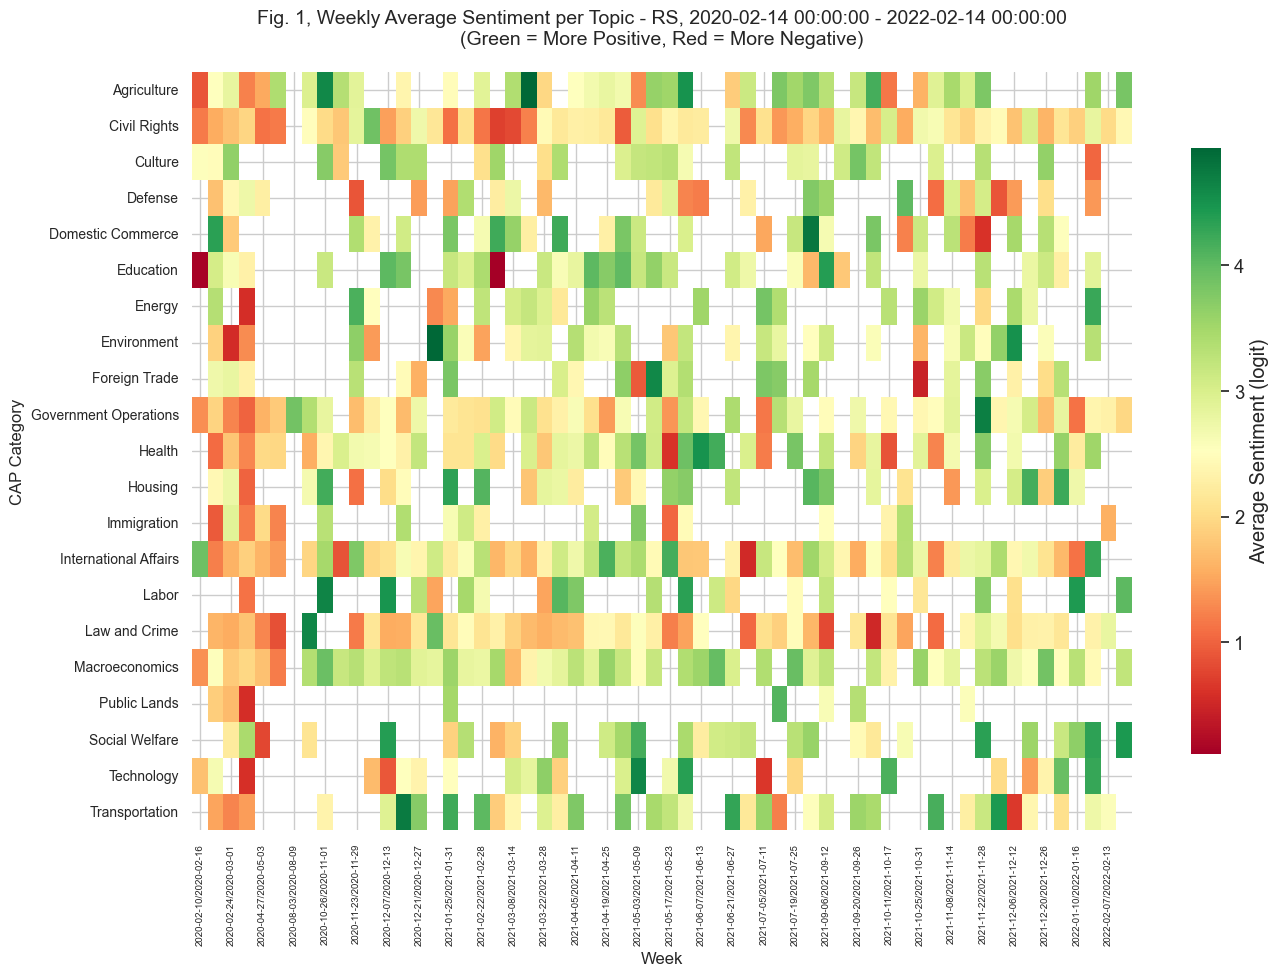

In [26]:
# ---- 1. Choose a target country ----
target_country = "RS"  # Change this to any country code: "DE", "IT", "GB", etc.

# ---- 2. Filter for the country and ensure date is datetime ----
country_df = filtered_all_custom[filtered_all_custom['country'] == target_country].copy()
country_df['date'] = pd.to_datetime(country_df['date'])
country_df['week'] = country_df['date'].dt.to_period('W').astype(str) # Create a 'week' period column

# ---- 3. Group by Week and CAP Category, calculate mean sentiment ----
weekly_sentiment = country_df.groupby(['week', 'CAP_category'])['sent_logit'].mean().reset_index()

# ---- 4. Pivot the table: Weeks as rows, CAP Categories as columns ----
heatmap_data_country = weekly_sentiment.pivot(index='week', columns='CAP_category', values='sent_logit')

# ---- 5. Plot the heatmap ----
plt.figure(figsize=(14, 10))  

sns.heatmap(
    heatmap_data_country.T,  
    cmap="RdYlGn",                      
    cbar_kws={"label": "Average Sentiment (logit)", "shrink": 0.8},
    square=False           
)

plt.title(f'Fig. 1, Weekly Average Sentiment per Topic - {target_country}, {custom_start} - {custom_end}\n(Green = More Positive, Red = More Negative)', fontsize=14, pad=20)
plt.xlabel("Week", fontsize=12)
plt.ylabel("CAP Category", fontsize=12)
plt.xticks(rotation=90, ha='center', fontsize=7)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

*Figure 1, visualized the **weekly average sentiment** of parliamentary debates across all **21 major policy topics** over a two-year period. The key finding is that sentiment across almost all topics was significantly more negative in **early 2020**, which also marks the onset of the COVID-19 pandemic. This drop in sentiment across topics is followed by cluster of missing data for majority of topics, indicating that the parliament might have been in lockdown too (similar gaps can also visible during the official summer breaks of a parliament) or focused much more on a few topics like 'Government Operations' as a reaction to the COVID outbreak.*

*Connected to that, the 'Health' topic shows one of the most dramatic and sustained negative shifts. It turns dark red and stays predominantly negative for the entire period. This could reflect the ongoing crisis. Economy-related topics, such as 'Macroeconomics' or 'Social Welfare' also show strong negative reactions which could indicate the economic uncertainty of the early pandemic. 'Government Operations' also turns very red in this period.*

**4.1. Time series for a specific top (Example: Serbia (RS))**

Figure 1 shows sentiment across all topics in the selected country (Serbia), highlighting general trends. To get a clearer overview of topic-specific dynamics over time (and for better readibility of the dates), we can examine the weekly sentiment for one chosen CAP category.

In the following part, 'Health' was chosen because it showed one of the most pronounced sentiment shifts durint the chosen time period, reflecting the parliament's response to the COVID-19 outbreak.



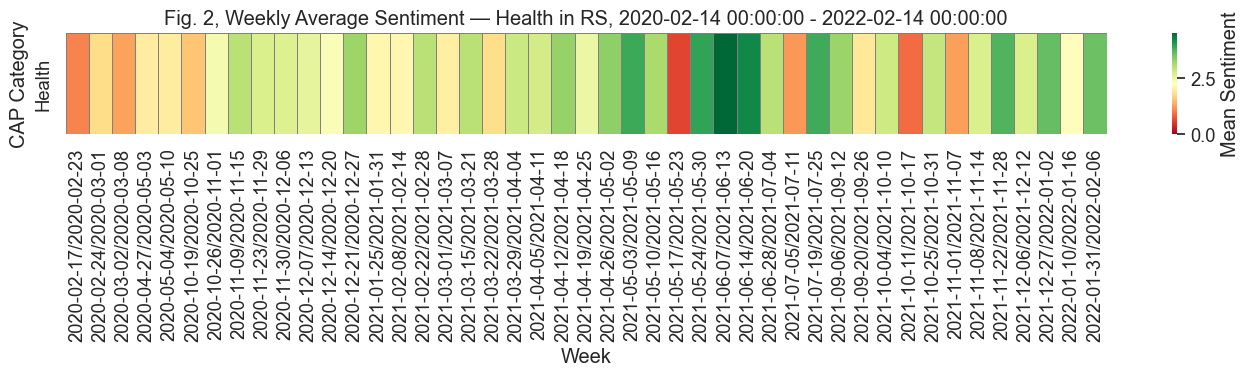

In [32]:
# ---- 1. Choose target country and CAP category ----
target_country = "RS"
category = "Health"

# ---- 2. Filter the dataset for the selected country and category ----
category_df = filtered_all_custom[
    (filtered_all_custom["country"] == target_country) &
    (filtered_all_custom["CAP_category"] == category)
].copy()

# ---- 3. Group by week and calculate mean sentiment ----
category_over_time = (
    category_df
    .groupby([pd.Grouper(key="date", freq="W")])
    .agg(mean_sent=("sent_logit", "mean"))
    .reset_index()
)

# ---- 4. Make sure 'date' is datetime and create week period ----
category_over_time["date"] = pd.to_datetime(category_over_time["date"], errors="coerce")
category_over_time["week"] = category_over_time["date"].dt.to_period("W").astype(str)

# ---- 5. Pivot the data to have weeks as columns ----
# Use a constant string for the row since we only have one CAP category
heatmap_data = category_over_time.pivot_table(
    index=[pd.Series([category]*len(category_over_time), name="CAP_category")],  
    columns="week",
    values="mean_sent",
    aggfunc="mean"
)

# ---- 6. Plot Heatmap ----
plt.figure(figsize=(14, 4))  # smaller height since only one row
sns.heatmap(
    heatmap_data,
    cmap="RdYlGn",
    vmin=0,  
    vmax=4.5,
    annot=False,              
    cbar_kws={'label':'Mean Sentiment'},
    linewidths=0.5,
    linecolor='gray'
)
plt.title(f"Fig. 2, Weekly Average Sentiment — {category} in {target_country}, {custom_start} - {custom_end}")
plt.xlabel("Week")
plt.ylabel("CAP Category")
plt.xticks(rotation=90, ha="center")
plt.tight_layout()
plt.show()


*Figure 2 displays a concise overview of the weekly avg. sentiment of the Serbian parliament regarding all speeches related to 'Health'. We can see a sharp and lasting negative shift at the beginning of our chosen time frame (March 2020), coinciding with the outbreak of COVID-19. After this initial crahs, the 'Health' topic remains largely negative, with a particular shar drop in May 2021, followed by a noticeable rebound in the weeks that followed. To investigate whether there were events causing the sentiment spike, one could examine **concordances** of the speeches - but that would go beyond the scope of this tutorial.*

At the same time, this approach can also be flipped around: if you want to explore how specific events (e.g. elections, protests, war etc.) influenced the emotional tone of debates in parliament, you can simply choose a CAP category and trace how its sentiment shifted over time.



**4.2 How does the sentiment change towards 'Health' differ in parliamentary debates in RS, (HR) and (HU)? (cross-country comparison)**

So far, we have explored sentiment within Serbia's parliament to understand how debates on 'Health' evolved over time. While this shows the internal dynamics of one country, it doesn't tell us whether similar shifts occurred elsewhere. To put Serbia's trajectory into context, we can compare it with neighboring countries like **Croatia (HR)** and **Hungary (HU)**.

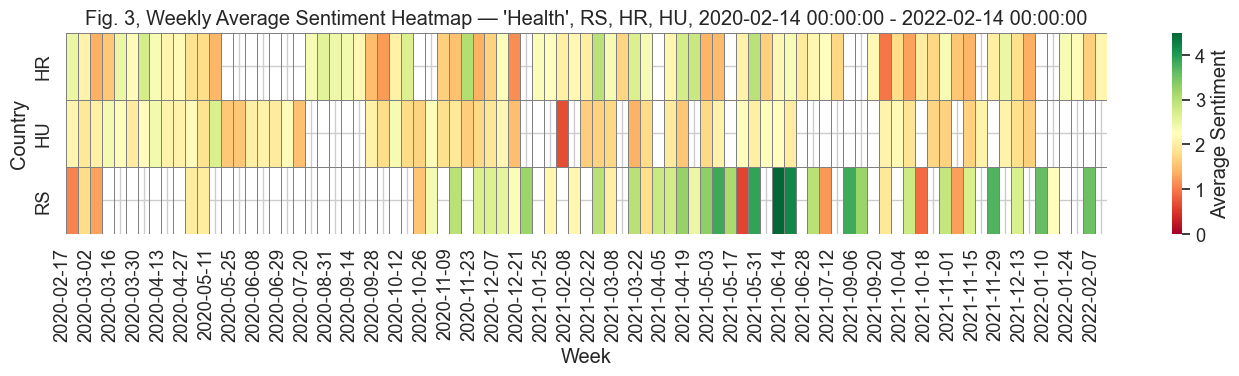

In [36]:
# ---- 1. Choose the CAP category you want to focus on ----
category = "Health"

# ---- 2. Filter dataset for the category and selected countries ----
countries_to_compare = ["RS", "HR", "HU"]
category_df = filtered_all_custom[
    (filtered_all_custom["CAP_category"] == category) &
    (filtered_all_custom["country"].isin(countries_to_compare))
].copy()

# ---- 3. Ensure 'date' is datetime and create a 'week' column ----
category_df["date"] = pd.to_datetime(category_df["date"], errors="coerce")
category_df["week"] = category_df["date"].dt.to_period("W").dt.start_time  # first day of the week

# ---- 4. Group by country + week and calculate mean sentiment ----
weekly_sentiment = (
    category_df
    .groupby(["country", "week"])
    .agg(mean_sent=("sent_logit", "mean"))
    .reset_index()
)

# ---- 5. Plot Heatmap ----
# Pivot to have countries as rows, weeks as columns
heatmap_data = weekly_sentiment.pivot(index="country", columns="week", values="mean_sent")

# Optional: convert week to string for better labeling
heatmap_data.columns = heatmap_data.columns.astype(str)

plt.figure(figsize=(14,4))
sns.heatmap(
    heatmap_data,
    cmap="RdYlGn",
    vmin=0,
    vmax=4.5,
    annot=False,
    cbar_kws={'label':'Average Sentiment'},
    linewidths=0.5,
    linecolor='gray'
)
plt.title(f"Fig. 3, Weekly Average Sentiment Heatmap — '{category}', RS, HR, HU, {custom_start} - {custom_end}")
plt.xlabel("Week")
plt.ylabel("Country")
plt.xticks(rotation=90, ha="right")
plt.tight_layout()
plt.show()


*Figure 3 highlights that Serbia's sharp drop, the big gab in the data and subsequent recovery of sentiment in weekly sentiment on 'Health' debates is unique in this cross-country comparison. There are also gaps in the Hungary (HU) and Croatia (HR) datasets but it is likely that these reflect the annual parliamentary summer break. Prior to this, both countries exhibit consistently negative discussions on health. Croatia's parliament shows more fluctuations between positive and negative sentiment, while Hungary maintains a persistently negative baseline, with a pronounced drop in late winter 2021. This drop coincides with the second wave of COVID-19 and rising case numbers and deaths, which likely contributed to the heightened negativity in parliamentary speeches. To confirm this theory, a closer look into the actual parliamentary speeches, e.g. a keyword analysis, might be necessary.*

In the next part of the tutorial, we will shift our focus from **sentiment analysis** - how parliaments reacted emotionally to major events like the COVID-19 pandemic - to **topic attention*, that is, how much speech was devoted to specific topics and how has this changed over time? This approach will help answer questions such as:

**5. How did attention to 'Health' evolve in Serbia, Hungary and Croatia?**

In order to reply to this question we define the right CAP category and the countries we want to investigate in the first part of our code (below). Then we have to make sure that the 'date' column in our DataFrame 'filtered_all_custom' is treated as actual dates ('datetime') instead of text. Then we create a new column called 'week', which groups all speeches by the week they were delivered. 
After that we sum up the **total numbers of words spoken** about the chosen topic for each country and each week. Then, the data is reshaped so that **countries become rows** and **weeks become columns**. Additionally, normalize the weekly word counts by dividing each week's word counts by the total for that week across all countries. This prevents a country with a generally larger parliament from dominating the chart. Finally, we create a heatmap.

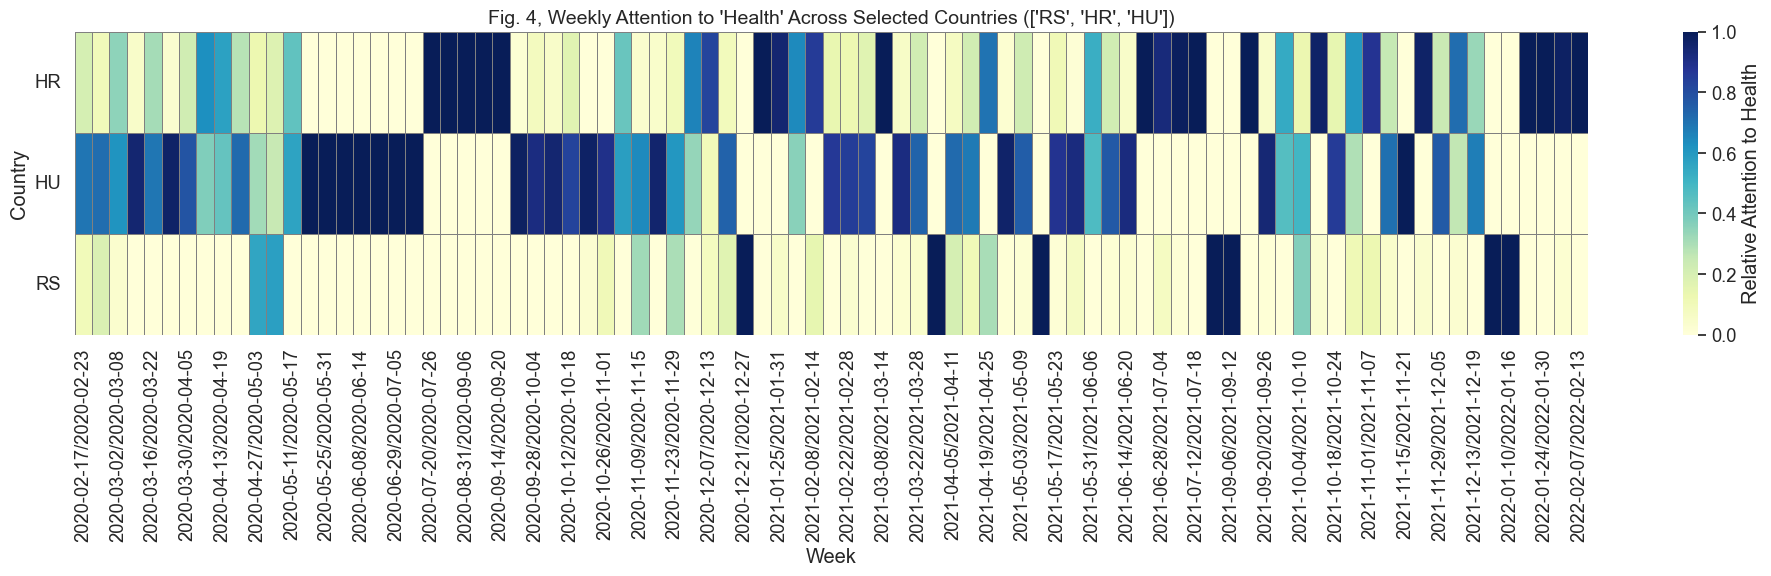

In [45]:
# ---- 1. Choose the CAP category and countries to focus on ----
category = "Health"  # <-- change to any CAP category you want
countries_to_plot = ["RS", "HR", "HU"]  # <-- change or add countries here

# ---- 2. Filter the dataset for the chosen category and countries ----
category_df = filtered_all_custom[
    (filtered_all_custom["CAP_category"] == category) &
    (filtered_all_custom["country"].isin(countries_to_plot))
].copy()

# ---- 3. Make sure 'date' is datetime and create 'week' column ----
category_df['date'] = pd.to_datetime(category_df['date'], errors='coerce')
category_df['week'] = category_df['date'].dt.to_period('W').astype(str)

# ---- 4. Group by country + week and sum word counts ----
weekly_wordcount = (
    category_df
    .groupby(['country', 'week'])['word_count']
    .sum()
    .reset_index()
)

# ---- 5. Pivot to get countries as rows, weeks as columns ----
heatmap_data = weekly_wordcount.pivot(index='country', columns='week', values='word_count').fillna(0)

# ---- 6. Ensure numeric dtype ----
heatmap_data = heatmap_data.fillna(0).astype(float)

# ---- 7. Normalize per week for fair cross-country comparison ----
heatmap_data_norm = heatmap_data.div(heatmap_data.sum(axis=0), axis=1)

# ---- 8. Plot the heatmap ----
plt.figure(figsize=(20, 6))
sns.heatmap(
    heatmap_data_norm,
    cmap="YlGnBu",
    cbar_kws={'label': f'Relative Attention to {category}'},
    linewidths=0.5,
    linecolor='gray',
    annot=False
)
plt.title(f"Fig. 4, Weekly Attention to '{category}' Across Selected Countries ({countries_to_plot})", fontsize=14)
plt.xlabel("Week")
plt.ylabel("Country")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


*Figure 4 shows that the Hungarian parliament consistently devoted the most attention to the 'Health' topic among the three selected countries, with particularly strong activity in the first half and autumn of 2020. Croatia’s parliament also exhibits noticeable spikes in discussion on health during the same periods. Overall, both Hungary and Croatia display higher levels of attention to this topic than Serbia throughout the year.*

**6. Conclusion**

In this tutorial, we examined parliamentary debates **over time** from two perspectives:
1) **Sentiment**: Weekly average sentiment can highlight how events (like COVID-19) shaped emotional tone. This can reflect in sharp drops or a prolonged negative baseline, as we saw in 'Health' debates. The cross-country comparisons revealed differences in how much sentiment fluctuates and how strongly opinions were expressed. 
2) **Topic attention**: Weekly word counts showed which parliaments focused most on specific topics. Hungary consistently emphasized 'Health', Croatia had spikes at key moment, and Serbia's attention remained lower.

Together, these analyses demonstrate how tracking sentiment and attention over time provides insights into both **what parliaments discussed** and **how intensely they engages** with each topic.